#Импорт библиотек

In [ ]:
!pip install orix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.1/308.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffpy.structure: filename=diffpy.structure-3.1.0-py3-none-any.whl size=172831 sha256=558cae95305ea3dba6115b9e19899392ecad1bfa189c1cf96f87713fc9812ebc
  Stored in directory: /root/.cache/pip/wheels/5b/33/86/dde093d7a37d2d2c7342f3f575321fa2bac69ab376f89356d3
  Created wheel for pycifrw: filename=PyCifRW-4.4.5-cp310-cp310-linux_x86_64.whl size=163214 sha256=417e3b7d6da2c9ef431b61df82f5074478cec494e1a882df93b33ad3058c42d8
  Stored in directory: /root/.cache/pip/wheels/fd/49/f

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, BatchNormalization, Input, concatenate, Add
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.utils import img_to_array
from PIL import Image
from tensorflow.keras.losses import MeanAbsoluteError
import math
from orix import data, plot
from orix.quaternion import Orientation, symmetry
from orix.vector.vector3d import Vector3d
from orix.quaternion.symmetry import get_point_group
from sklearn import preprocessing
import matplotlib.colors as mcolors
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import load_model

In [ ]:
colors = mcolors.BASE_COLORS
colors.pop('k')
colors.pop('w')
colors['g'] = (0, 1, 0)
colors['c'] = (0, 1, 1)
colors['m'] = (1, 0, 1)
colors['y'] = (1, 1, 0)

#Вспомогательные функции

## Перевод в классы

### в 3 класса

In [ ]:
def euler_to_class(euler):
  solution_vectors_1 = Orientation.from_euler(euler, degrees=True)
  ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
  rgb_z = ipfkey.orientation2color(solution_vectors_1)
  if rgb_z[0,0] == 1.0:
    return 'r'
  if rgb_z[0,1] == 1.0:
    return 'g'
  if rgb_z[0,2] == 1.0:
    return 'b'

### в 6 классов

In [ ]:
def distance(x,y):
    dx = x[0]-y[0]
    dy = x[1]-y[1]
    dz = x[2]-y[2]
    return math.sqrt(dx*dx+dy*dy+dz*dz)

def findclosest(pixel):
    solution_vectors_1 = Orientation.from_euler(pixel, degrees=True)
    ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
    rgb_z = ipfkey.orientation2color(solution_vectors_1)
    mn = 999999
    for key in colors:
        d = distance(rgb_z[0], colors[key])
        if d < mn:
            mn = d
            name_color = key
    return name_color

## Визуализация изображений

In [ ]:
def show_images(index, rows):
  columns = 4
  fig, ax = plt.subplots(rows, columns, figsize=(10,6))
  num = 1
  for i in range(rows):
    for j in range(columns):
      img = raw_data[index]['data'][j][i]
      num = num + 1
      ax[i,j].imshow(img)
  plt.show()

##Алгоритм разбиения



In [ ]:
def empty_zones(array):
  check_array = array[:,:,:,3].flatten().tolist()
  if check_array.count(0) == 0 and np.array(array).shape[1] == 10 and np.array(array).shape[2] == 10:
    return True
  else:
    return False

In [ ]:
def image_files_to_array_custom(dir):
  result_arr = list()
  amount = len(os.listdir(dir+'/1'))
  for k in range(amount):
    max_width = 0
    max_height = 0
    for i in range(4):
      img = Image.open(dir+'/'+str(i+1)+'/'+str(k+1)+'.png').convert('RGBA')
      full_array = img_to_array(img)
      if max_width < full_array.shape[1]:
        max_width = full_array.shape[1]
      if max_height < full_array.shape[0]:
        max_height = full_array.shape[0]
    full_array = list()
    for i in range(4):
      img = Image.open(dir+'/'+str(i+1)+'/'+str(k+1)+'.png').resize((max_height, max_width), resample= Image.NEAREST).convert('RGBA')
      arr = img_to_array(img)
      full_array.append(arr)
    new_array = list()
    full_array = np.array(full_array)
    new_array2 = list()
    for ij in range(4):
      for i in range(max_height-10):
        for j in range(max_width-10):
          if empty_zones(full_array[:, j:j + 10, i:i + 10, :]):
            new_array.append(full_array[ij, j:j + 10, i:i + 10, :3])
      new_array2.append(new_array)
      new_array = list()
    new_array2 = np.array(new_array2)
    result_arr.append(new_array2 / 255)
  return result_arr

In [ ]:
start_dir = '/content/drive/MyDrive/новые данные для Димы (1 часть)/'
save_dir = '/content/drive/MyDrive/работа с картинками/Дневник_колаб/input_data/алгоритм/Nearest/'
dir_list = os.listdir(start_dir)
for dir in dir_list:
  file_list = os.listdir(start_dir+dir)
  for file_name in file_list:
    result = image_files_to_array_custom(start_dir+dir+'/'+file_name)
    for res in result:
      if res.shape[1] == 0:
        result.remove(res)
    if len(result) != 0:
      result = np.hstack(tuple(result))
      np.save(save_dir+dir+'_'+file_name+'.npy', result)

##Алгоритм сортировки данных

In [ ]:
def findfarest(x, y, euler_data):
    solution_vectors_1 = Orientation.from_euler(euler_data, degrees=True)
    ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
    rgb_z = ipfkey.orientation2color(solution_vectors_1)
    mn = 999999
    for key in colors:
        d = distance(rgb_z[x], rgb_z[y])
        if d < mn:
            mn = d
            name_color = key
    return name_color

In [ ]:
def sort_data(data, train_rate=0.6, val_rate=0.2, test_rate=0.2):
  train_index = list()
  val_index = list()
  test_index = list()
  r_list = list()
  b_list = list()
  y_list = list()
  c_list = list()
  m_list = list()
  g_list = list()
  for i in range(len(data)):
    if data[i]['class'] == 'r':
      r_list.append(i)
    if data[i]['class'] == 'b':
      b_list.append(i)
    if data[i]['class'] == 'y':
      y_list.append(i)
    if data[i]['class'] == 'g':
      g_list.append(i)
    if data[i]['class'] == 'c':
      c_list.append(i)
    if data[i]['class'] == 'm':
      m_list.append(i)
  train_index.append(r_list[0])
  train_index.append(b_list[0])
  train_index.append(y_list[0])
  train_index.append(c_list[0])
  train_index.append(m_list[0])
  train_index.append(g_list[0])
  for i in r_list:
      train_index.append(i)
    new_list = [x: for x in r_list and not in train_index]
    for i in new_list:

  return train_index, val_index, test_index

#Загрузка данных

In [ ]:
min_count = 100
max_count = 100
raw_data = list()
filter = 'Lanczos/'

In [ ]:
directory = '/content/drive/MyDrive/работа с картинками/Дневник_колаб/input_data/алгоритм/'
file_names = os.listdir(directory+filter)
file_names.sort()
for file in file_names:
  input = np.load(directory+filter+file, allow_pickle=True)
  count = input.shape[1]
  name = file[:-4]
  data = [float(x) for x in name[name.index('_')+1:name.index(' [')].split(';')]
  if count>=min_count:
    if count>max_count:
      raw_data.append({'data':input[:,:max_count,:,:,:], 'class':findclosest(data),'euler':data, 'amount':count, 'taken_amount':max_count})
    else:
      raw_data.append({'data':input, 'class':findclosest(data),'euler':data, 'amount':count, 'taken_amount':count})

In [ ]:
directory = '/content/drive/MyDrive/работа с картинками/Дневник_колаб/input_data/для 4х изображений/'
output_dir = '/content/drive/MyDrive/работа с картинками/Дневник_колаб/output_data/для 4х изображений/'
file_names = os.listdir(directory)
file_names.sort()
for file in file_names:
  input = np.load(directory+file, allow_pickle=True)
  data = np.load(output_dir+file).reshape(-1).tolist()
  count = input.shape[1]
  raw_data.append({'data':input, 'class':findclosest(data),'euler':data, 'amount':count, 'taken_amount':count})

In [ ]:
def empty_zones(array):
  check_array = array[:,:,:,3].flatten().tolist()
  if check_array.count(0) == 0 and np.array(array).shape[1] == 10 and np.array(array).shape[2] == 10:
    return True
  else:
    return False

In [ ]:
dir = '/content/drive/MyDrive/test/'
result_arr = list()
for k in range(4,7):
  max_width = 0
  max_height = 0
  for i in range(4):
    img = Image.open(dir+'/'+str(i+1)+'/'+str(k)+'.png').convert('RGBA')
    full_array = img_to_array(img)
    if max_width < full_array.shape[1]:
      max_width = full_array.shape[1]
    if max_height < full_array.shape[0]:
      max_height = full_array.shape[0]
  full_array = list()
  for i in range(4):
    img = Image.open(dir+'/'+str(i+1)+'/'+str(k)+'.png').resize((max_height, max_width), resample = Image.LANCZOS).convert('RGBA')
    arr = img_to_array(img)
    full_array.append(arr)
  new_array = list()
  full_array = np.array(full_array)
  new_array2 = list()
  for ij in range(4):
    for i in range(max_height-10):
      for j in range(max_width-10):
        if empty_zones(full_array[:, j:j + 10, i:i + 10, :]):
          new_array.append(full_array[ij, j:j + 10, i:i + 10, :3])
    new_array2.append(new_array)
    new_array = list()
  new_array2 = np.array(new_array2)
  result_arr.append(new_array2[:,:max_count,:,:,] / 255)

In [ ]:
raw_data.append({'data':result_arr[0], 'class':findclosest([282.5,14.5,15.1]),'euler':[282.5,14.5,15.1], 'amount':result_arr[0].shape[1], 'taken_amount':result_arr[0].shape[1]})
raw_data.append({'data':result_arr[1], 'class':findclosest([1.3,20.3,50.6]),'euler':[1.3,20.3,50.6], 'amount':result_arr[1].shape[1], 'taken_amount':result_arr[1].shape[1]})
raw_data.append({'data':result_arr[2], 'class':findclosest([146.7,53.2,45.1]),'euler':[146.7,53.2,45.1], 'amount':result_arr[2].shape[1], 'taken_amount':result_arr[2].shape[1]})

In [ ]:
r_list = list()
b_list = list()
y_list = list()
c_list = list()
m_list = list()
g_list = list()
for i in range(len(raw_data)):
  if raw_data[i]['class'] == 'r':
    r_list.append(i)
  if raw_data[i]['class'] == 'b':
    b_list.append(i)
  if raw_data[i]['class'] == 'y':
    y_list.append(i)
  if raw_data[i]['class'] == 'g':
    g_list.append(i)
  if raw_data[i]['class'] == 'c':
    c_list.append(i)
  if raw_data[i]['class'] == 'm':
    m_list.append(i)

In [ ]:
print('GREEN('+str(len(g_list))+'): '+str(g_list))
print('YELLOW('+str(len(y_list))+'): '+str(y_list))
print('CYAN('+str(len(c_list))+'): '+str(c_list))
print('BLUE('+str(len(b_list))+'): '+str(b_list))
print('RED('+str(len(r_list))+'): '+str(r_list))
print('MAGENTA('+str(len(m_list))+'): '+str(m_list))

GREEN(7): [15, 63, 65, 68, 74, 92, 93]
YELLOW(27): [1, 7, 8, 10, 11, 21, 22, 24, 26, 33, 41, 43, 46, 47, 49, 50, 51, 58, 69, 78, 81, 83, 84, 85, 87, 89, 90]
CYAN(26): [2, 3, 4, 6, 9, 12, 16, 17, 18, 19, 23, 25, 30, 38, 40, 48, 57, 60, 64, 70, 71, 82, 86, 88, 94, 95]
BLUE(14): [13, 28, 31, 35, 37, 39, 44, 53, 54, 62, 76, 79, 80, 99]
RED(11): [0, 5, 20, 27, 42, 52, 55, 72, 77, 91, 97]
MAGENTA(15): [14, 29, 32, 34, 36, 45, 56, 59, 61, 66, 67, 73, 75, 96, 98]


In [ ]:
euler_data = list()
for i in range(len(raw_data)):
  euler_data.append(raw_data[i]['euler'])
solution_vectors_1 = Orientation.from_euler(euler_data, degrees=True)

Text(0.5, 1.0, 'MAGENTA')

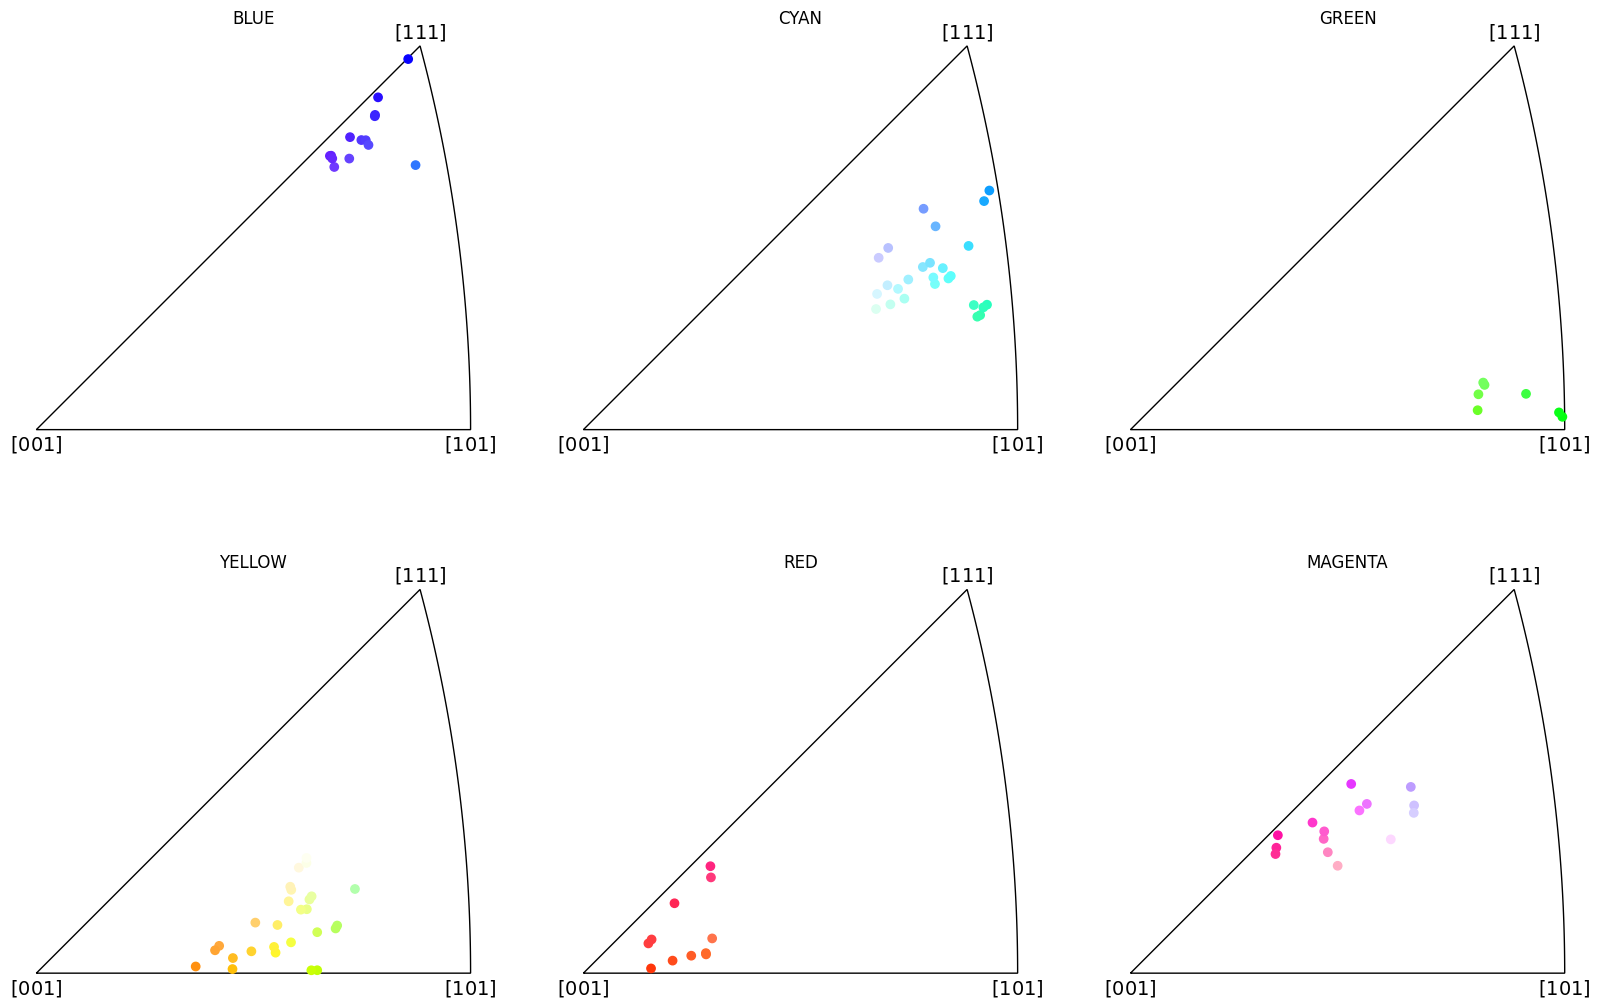

In [ ]:
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(20, 20))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
rgb_z = ipfkey.orientation2color(solution_vectors_1)

ax0 = fig.add_subplot(3, 3, 1, **subplot_kw)
ax0.scatter(solution_vectors_1[b_list], c = rgb_z[b_list], alpha=1)
ax0.set_title('BLUE')

ax1 = fig.add_subplot(3, 3, 2, **subplot_kw)
ax1.scatter(solution_vectors_1[c_list], c = rgb_z[c_list], alpha=1)
ax1.set_title('CYAN')

ax2 = fig.add_subplot(3, 3, 3, **subplot_kw)
ax2.scatter(solution_vectors_1[g_list], c = rgb_z[g_list], alpha=1)
ax2.set_title('GREEN')

ax3 = fig.add_subplot(3, 3, 4, **subplot_kw)
ax3.scatter(solution_vectors_1[y_list], c = rgb_z[y_list], alpha=1)
ax3.set_title('YELLOW')

ax4 = fig.add_subplot(3, 3, 5, **subplot_kw)
ax4.scatter(solution_vectors_1[r_list], c = rgb_z[r_list], alpha=1)
ax4.set_title('RED')

ax5 = fig.add_subplot(3, 3, 6, **subplot_kw)
ax5.scatter(solution_vectors_1[m_list], c = rgb_z[m_list], alpha=1)
ax5.set_title('MAGENTA')

#### GREEN GRAINS

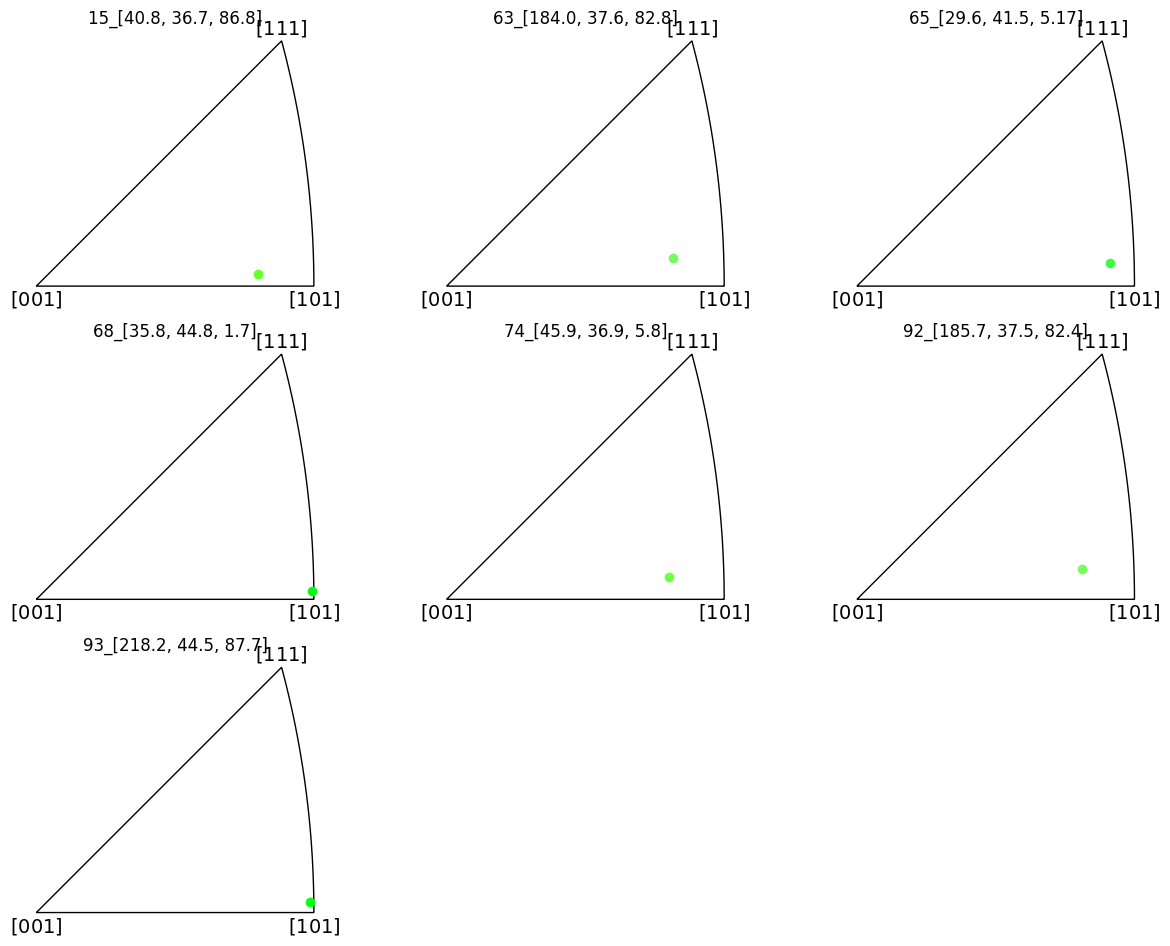

In [ ]:
num = 1
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(15, 40))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
for i in g_list:
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(10, 3, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(str(i)+'_'+str(raw_data[i]['euler']))

#### BLUE GRAINS

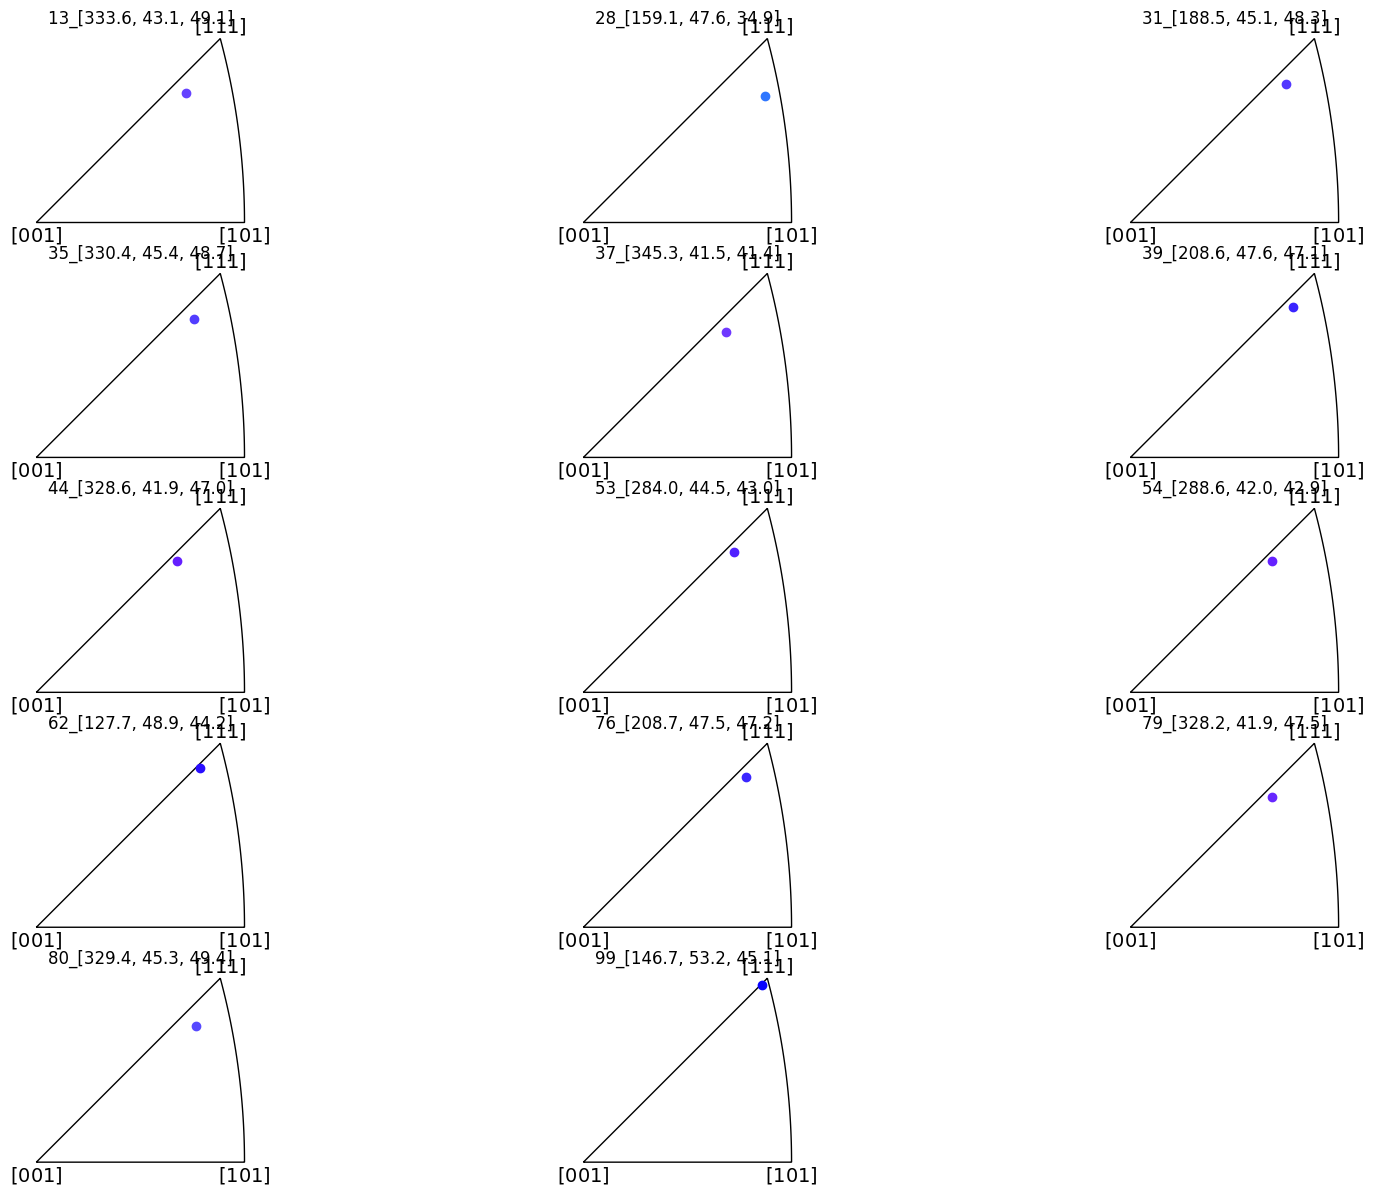

In [ ]:
num = 1
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(20, 30))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
for i in b_list:
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(10, 3, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(str(i)+'_'+str(raw_data[i]['euler']))

#### YELLOW GRAINS

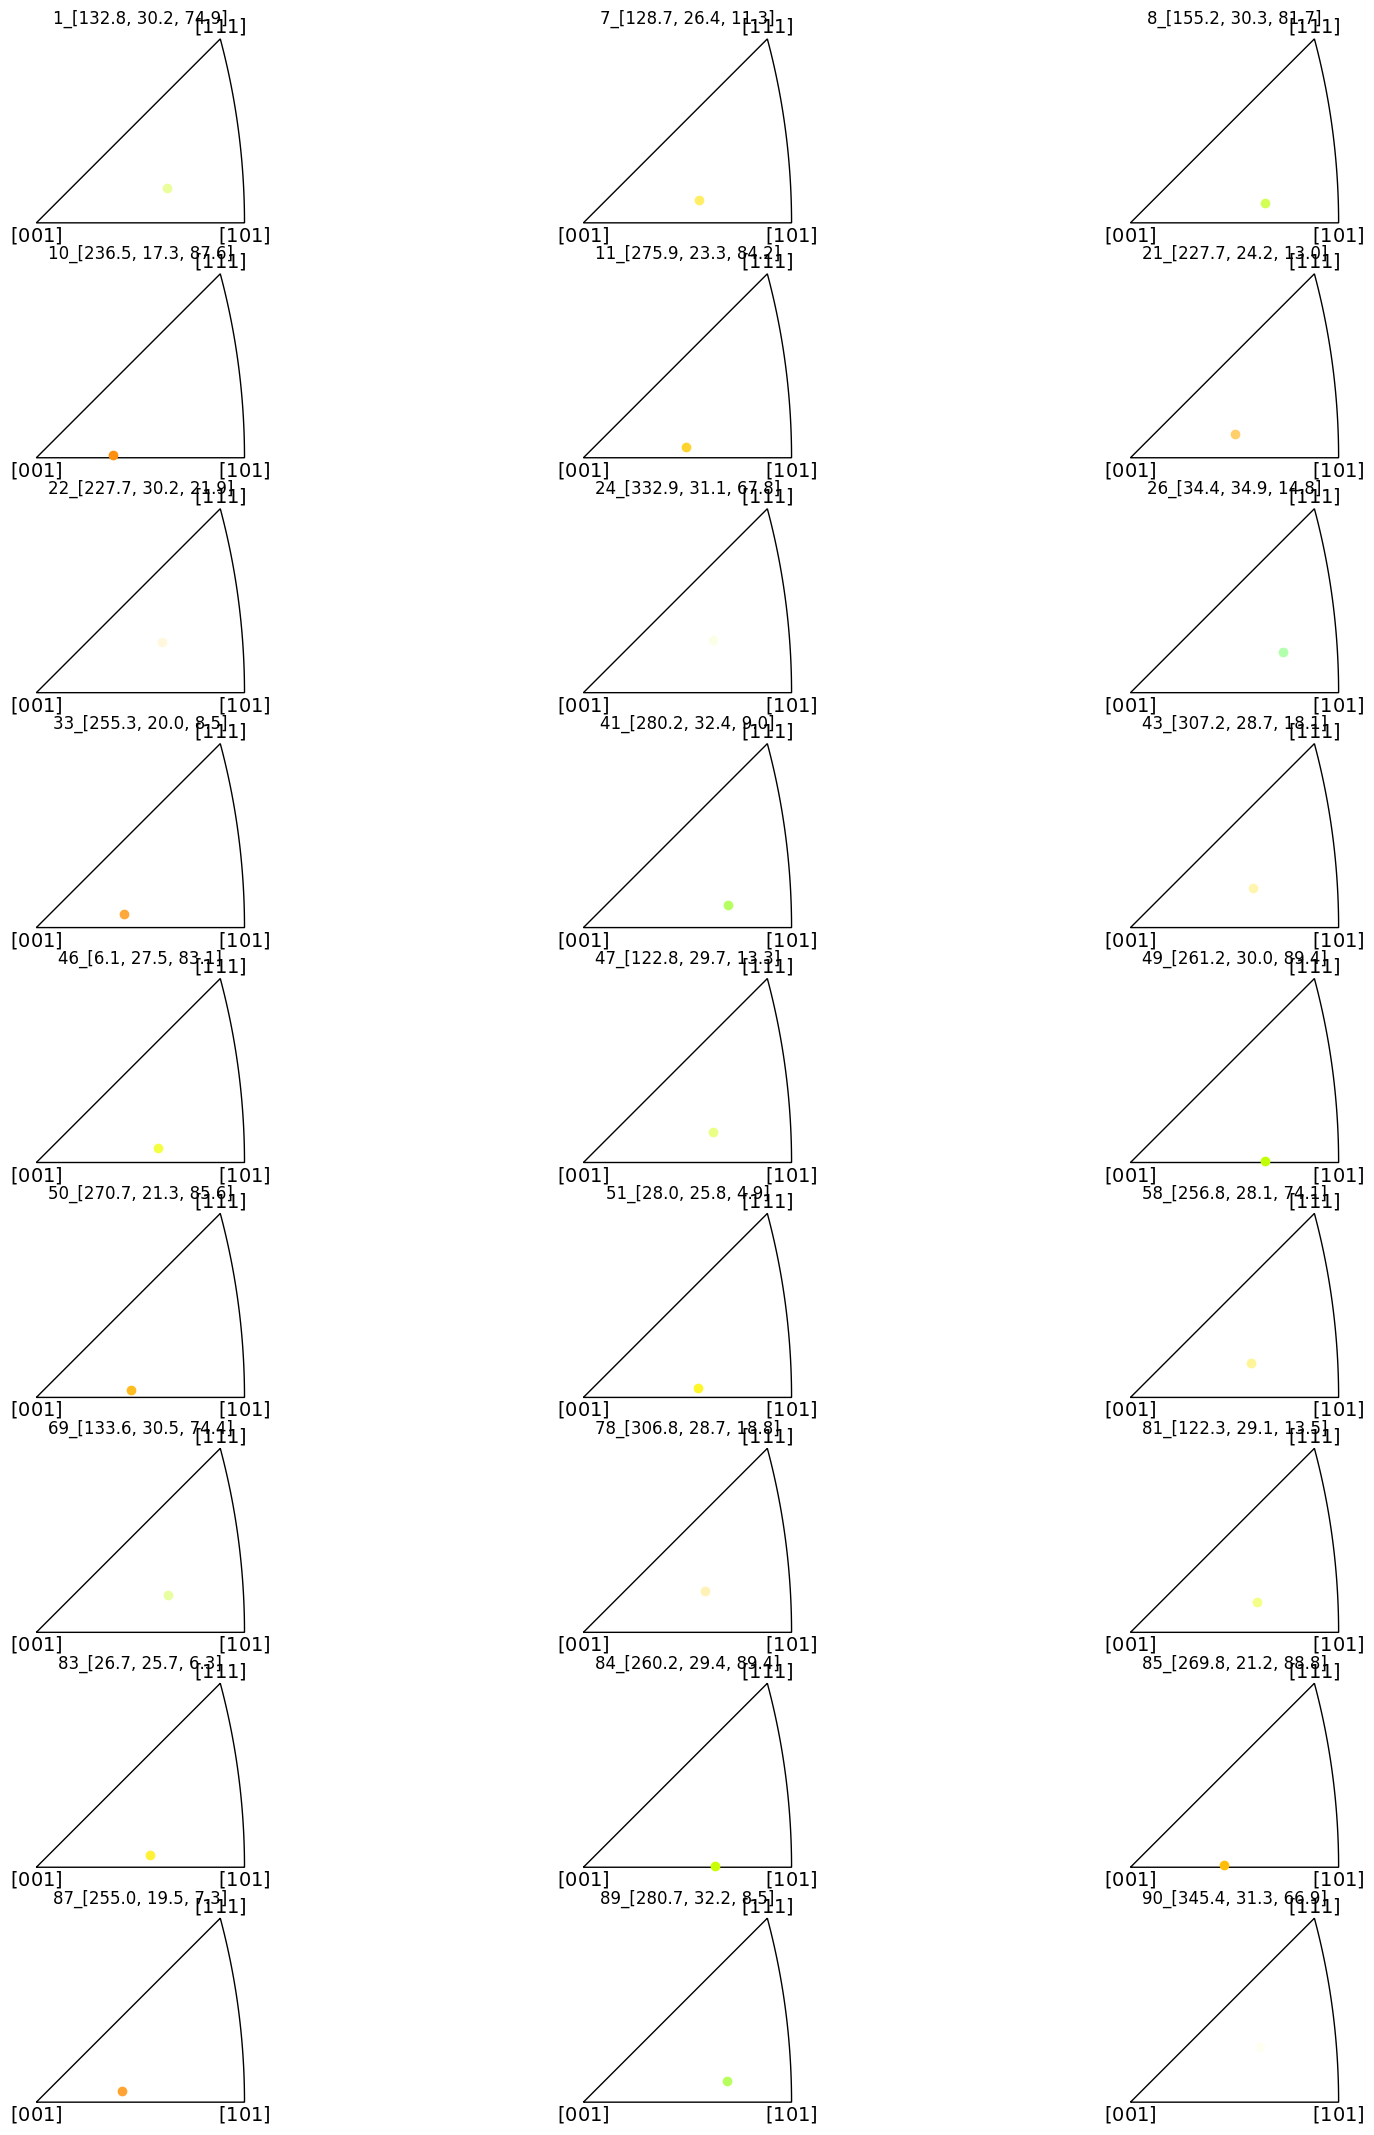

In [ ]:
num = 1
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(20, 30))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
for i in y_list:
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(10, 3, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(str(i)+'_'+str(raw_data[i]['euler']))

#### RED GRAINS

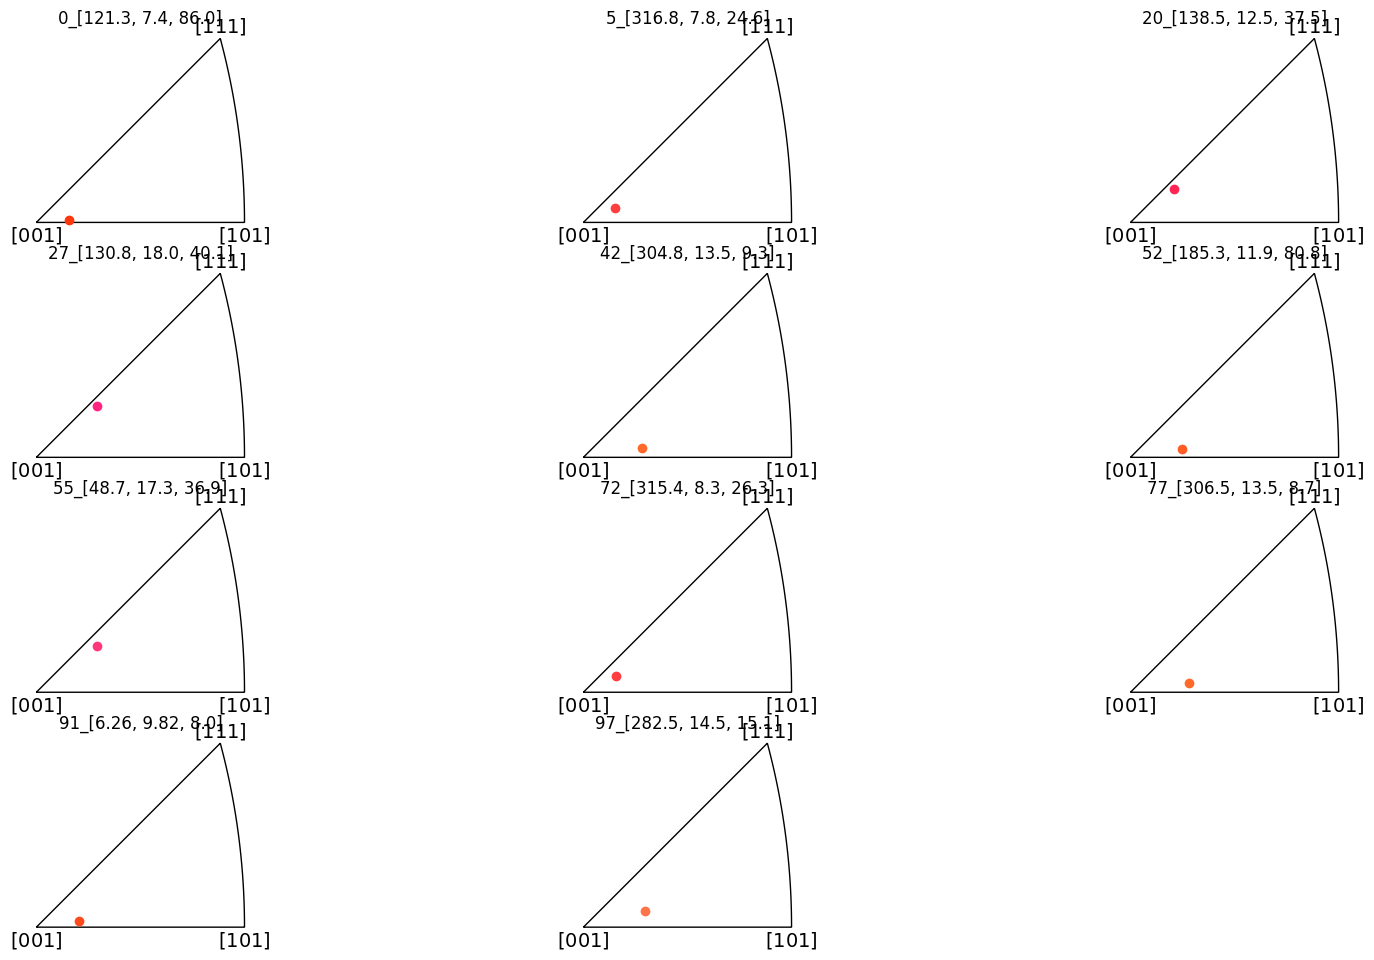

In [ ]:
num = 1
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(20, 30))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
for i in r_list:
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(10, 3, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(str(i)+'_'+str(raw_data[i]['euler']))

#### CYAN GRAINS

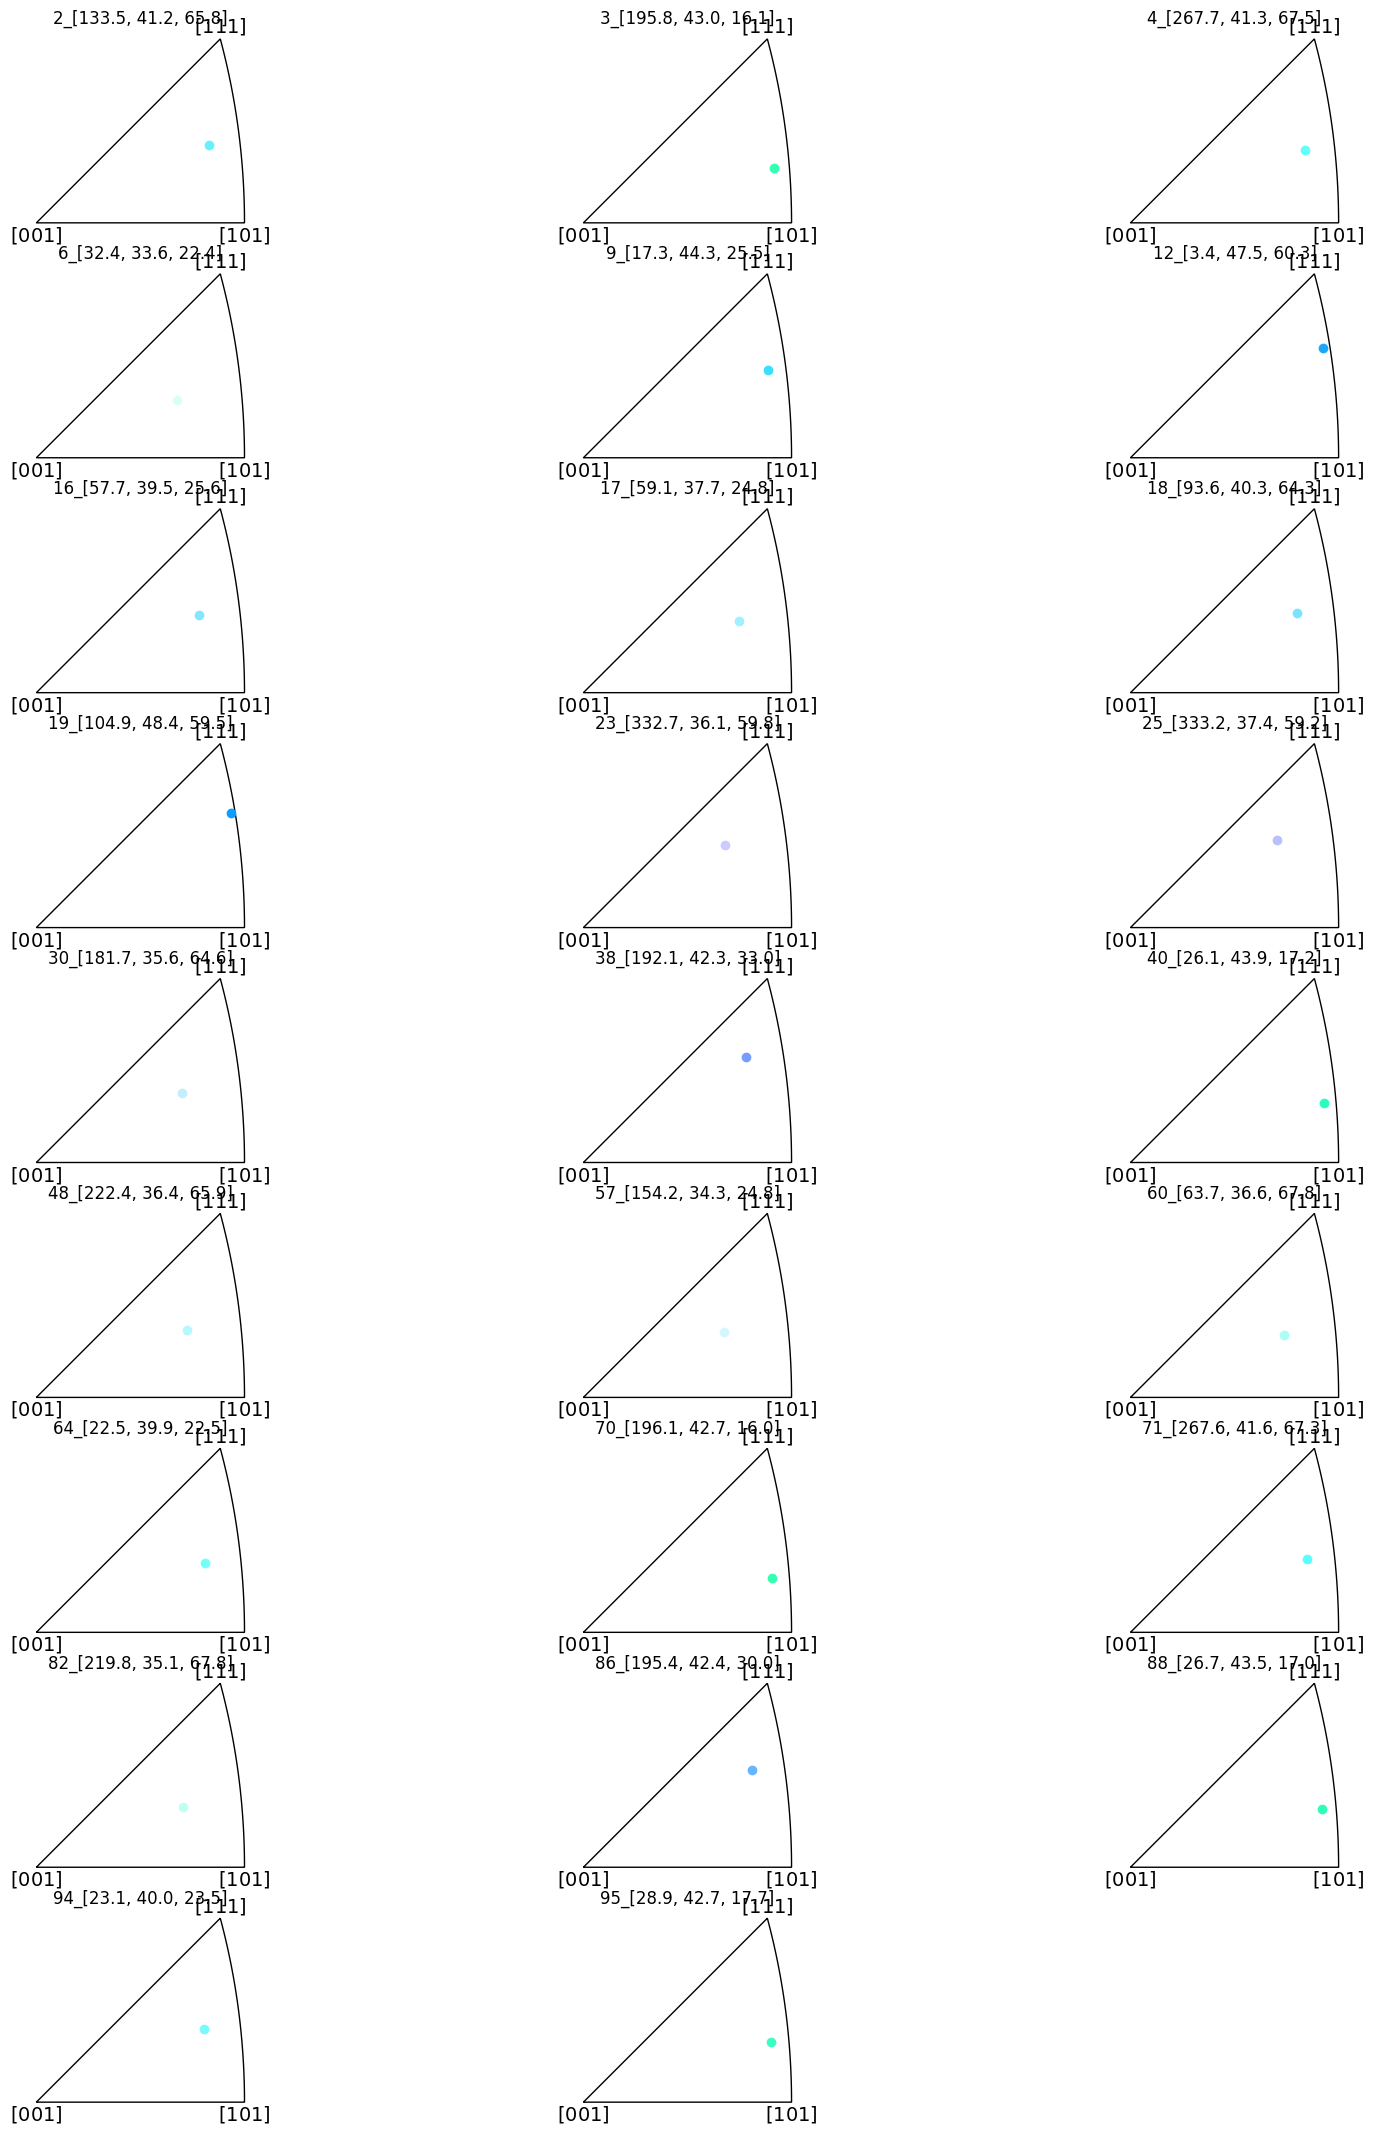

In [ ]:
num = 1
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(20, 30))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
for i in c_list:
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(10, 3, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(str(i)+'_'+str(raw_data[i]['euler']))

#### MAGENTA GRAINS

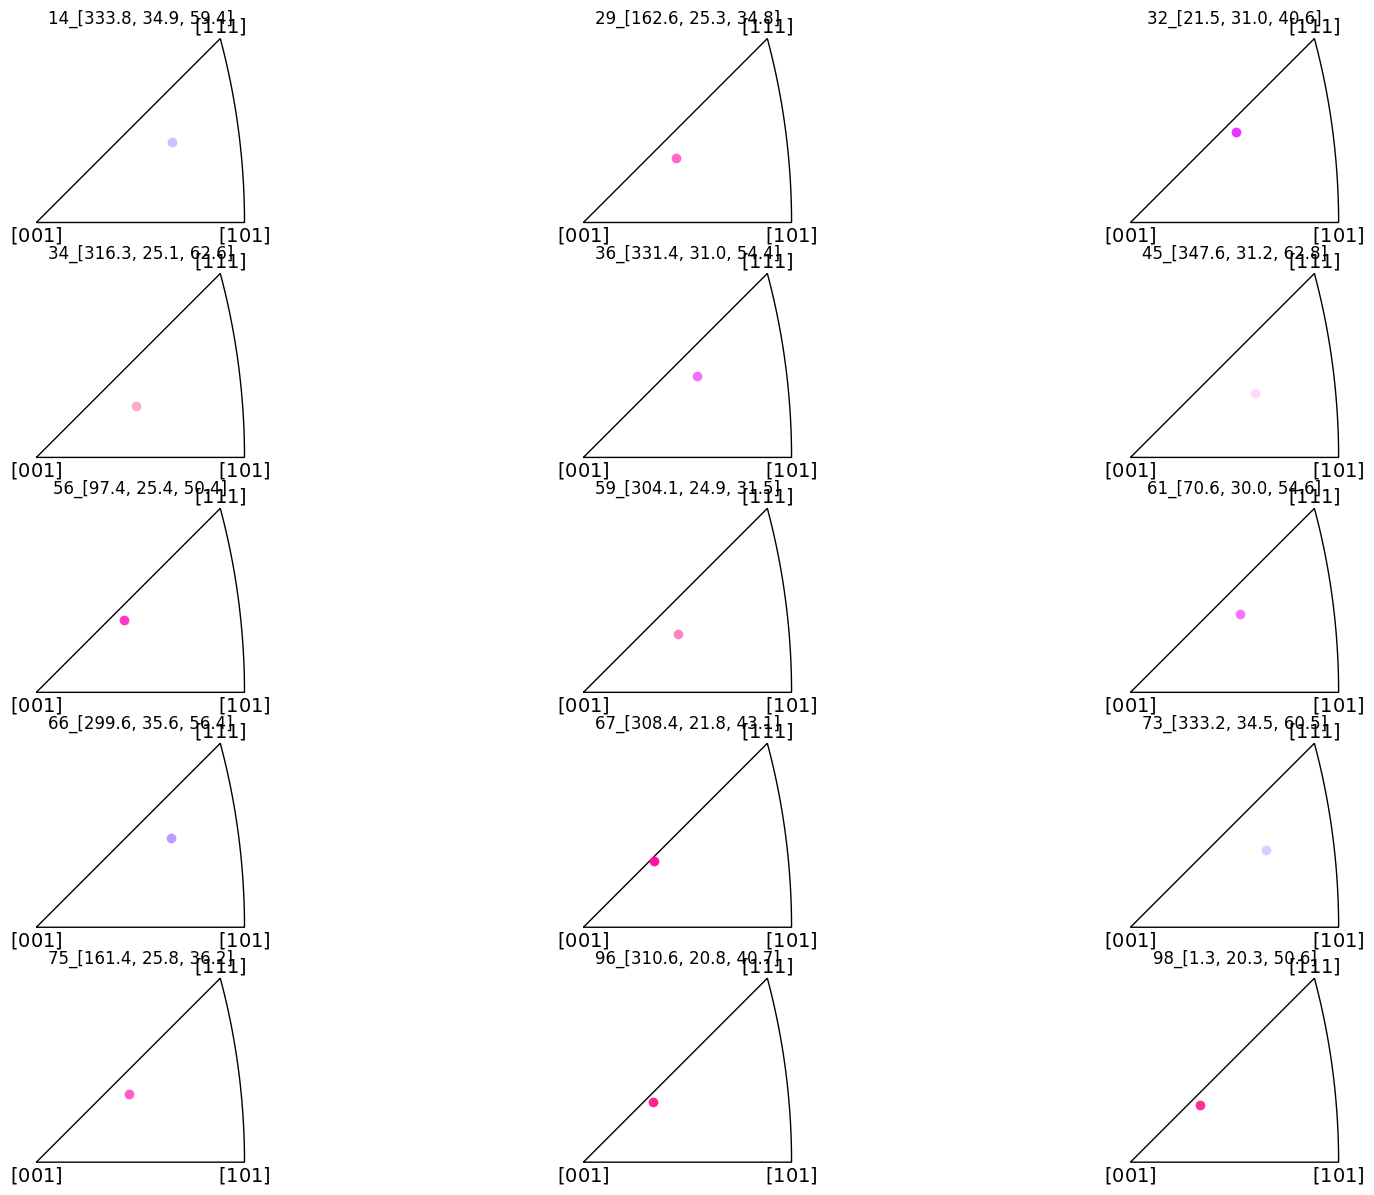

In [ ]:
num = 1
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(20, 30))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
for i in m_list:
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(10, 3, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(str(i)+'_'+str(raw_data[i]['euler']))

#### ALL GRAINS

In [ ]:
num = 1
for i in range(len(raw_data)):
  subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
  fig = plt.figure(figsize=(30, 30))
  ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
  rgb_z = ipfkey.orientation2color(solution_vectors_1[i])
  ax0 = fig.add_subplot(11, 10, num, **subplot_kw)
  num = num + 1
  ax0.scatter(solution_vectors_1[i], c = rgb_z, alpha=1)
  ax0.set_title(raw_data[i]['class']+'_'+str(i)+'_'+str(raw_data[i]['euler']))

### PREPARE DATA

Text(0.5, 1.0, 'All data')

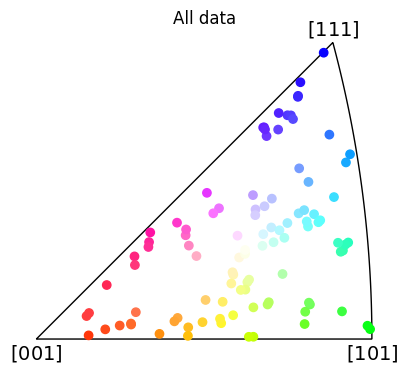

In [ ]:
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(10, 10))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
rgb_z = ipfkey.orientation2color(solution_vectors_1)
ax3 = fig.add_subplot(2, 2, 1, **subplot_kw)
ax3.scatter(solution_vectors_1, c = rgb_z, alpha=1)
ax3.set_title('All data')

In [ ]:
#train_index, val_index, test_index = sort_data(raw_data)
# g = 4 2 1 b = 9 3 2 c = 16 5 5 y = 17 5 5 m = 10 3 3 r = 7 2 2
g_train_index = [74, 63, 65, 93, 15]
b_train_index = [13, 28, 31, 39, 79, 99, 62, 37, 53]
c_train_index = [2, 3, 4, 6, 9, 12, 16, 19, 23, 25, 38, 40, 48, 60, 70, 95, 30]
y_train_index = [1, 7, 10, 11, 21, 22, 24, 26, 41, 43, 49, 50, 90, 69, 83, 89, 87]
m_train_index = [66, 29, 32, 34, 36, 45, 56, 61, 67, 98, 59]
r_train_index = [0, 5, 20, 27, 55, 91, 97]

g_val_index = [92]
b_val_index = [76, 80]
c_val_index = [17, 64, 82, 88]
y_val_index = [51, 78, 84]
m_val_index = [96]
r_val_index = [42, 72]

g_test_index = [68]
b_test_index = [54]
c_test_index = [57, 71, 86]
y_test_index = [33, 58, 81, 85]
m_test_index = [75]
r_test_index = [52, 77]

train_index = list()
val_index = list()
test_index = list()

train_index.extend(g_train_index)
train_index.extend(b_train_index)
train_index.extend(c_train_index)
train_index.extend(y_train_index)
train_index.extend(m_train_index)
train_index.extend(r_train_index)

val_index.extend(g_val_index)
val_index.extend(b_val_index)
val_index.extend(c_val_index)
val_index.extend(y_val_index)
val_index.extend(m_val_index)
val_index.extend(r_val_index)

test_index.extend(g_test_index)
test_index.extend(b_test_index)
test_index.extend(c_test_index)
test_index.extend(y_test_index)
test_index.extend(m_test_index)
test_index.extend(r_test_index)

train_index.sort()
val_index.sort()
test_index.sort()

Text(0.5, 1.0, 'All data')

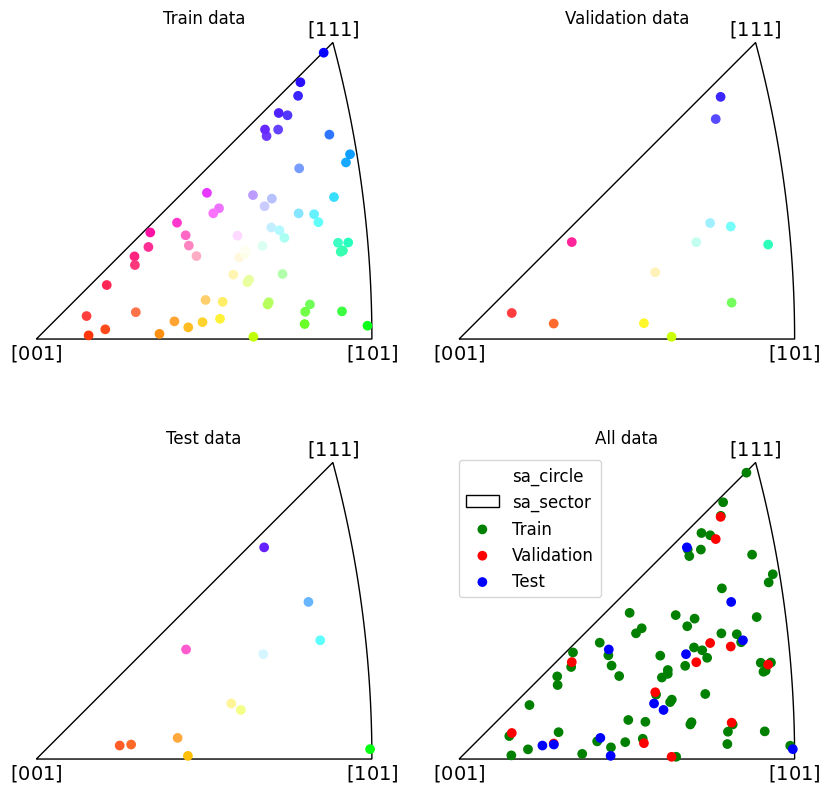

In [ ]:
subplot_kw = dict(projection="ipf", symmetry=symmetry.Oh)
fig = plt.figure(figsize=(10, 10))
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
rgb_z = ipfkey.orientation2color(solution_vectors_1)

ax0 = fig.add_subplot(2, 2, 1, **subplot_kw)
ax0.scatter(solution_vectors_1[train_index], c = rgb_z[train_index], alpha=1)
ax0.set_title('Train data')

ax1 = fig.add_subplot(2, 2, 2, **subplot_kw)
ax1.scatter(solution_vectors_1[val_index], c = rgb_z[val_index], alpha=1)
ax1.set_title('Validation data')

ax2 = fig.add_subplot(2, 2, 3, **subplot_kw)
ax2.scatter(solution_vectors_1[test_index], c = rgb_z[test_index], alpha=1)
ax2.set_title('Test data')


ax3 = fig.add_subplot(2, 2, 4, **subplot_kw)
ax3.scatter(solution_vectors_1[train_index], c = 'green', alpha=1, label = 'Train')
ax3.scatter(solution_vectors_1[val_index], c = 'red', alpha=1, label = 'Validation')
ax3.scatter(solution_vectors_1[test_index], c = 'blue', alpha=1, label = 'Test')
legend = ax3.legend(fontsize='large')
ax3.set_title('All data')

In [ ]:
output_data = list()
for i in range(len(raw_data)):
  output_data.append(raw_data[i]['class'])

print('ALL DATA')
print('green = '+str(output_data.count('g')))
print('blue = '+str(output_data.count('b')))
print('cyan = '+str(output_data.count('c')))
print('magenta = '+str(output_data.count('m')))
print('red = '+str(output_data.count('r')))
print('yellow = '+str(output_data.count('y')))

le = preprocessing.LabelEncoder()
le.fit(output_data)

ALL DATA
green = 7
blue = 13
cyan = 26
magenta = 14
red = 10
yellow = 27


LabelEncoder()

In [ ]:
np.save('classes.npy', le.classes_)

#Разработка нейросети

##Разбиение данных на выборки

In [ ]:
train_data = [raw_data[index]['data'] for index in train_index]
train_data = np.hstack(tuple(train_data))

val_data = [raw_data[index]['data'] for index in val_index]
val_data = np.hstack(tuple(val_data))

test_data = [raw_data[index]['data'] for index in test_index]
test_data = np.hstack(tuple(test_data))

train_output = list()
for i in train_index:
  train_output.extend([raw_data[i]['class']]*raw_data[i]['taken_amount'])

val_output = list()
for i in val_index:
  val_output.extend([raw_data[i]['class']]*raw_data[i]['taken_amount'])

test_output = list()
for i in test_index:
  test_output.extend([raw_data[i]['class']]*raw_data[i]['taken_amount'])

train_output = utils.to_categorical(le.transform(np.vstack(tuple(train_output))))
val_output = utils.to_categorical(le.transform(np.vstack(tuple(val_output))))
test_output = utils.to_categorical(le.transform(np.vstack(tuple(test_output))))

##Аугментация данных

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True,
        vertical_flip=True)

##Модель с 1им выходом

###Создание модели нейросети

In [ ]:
first_input = Input(shape = (10, 10, 3))
first_branch = first_input
filters = 64
for i in range(2):
  first_branch = Conv2D(filters = filters, kernel_size = (3, 3), padding = 'same', activation = 'relu')(first_branch)
  first_branch = BatchNormalization()(first_branch)
  first_branch = MaxPooling2D((2,2))(first_branch)
  first_branch = Dropout(0.25)(first_branch)
  filters *= 2

In [ ]:
second_input = Input(shape = (10, 10, 3))
second_branch = second_input
filters = 64
for i in range(2):
  second_branch = Conv2D(filters = filters, kernel_size = (3, 3), padding = 'same', activation = 'relu')(second_branch)
  second_branch = BatchNormalization()(second_branch)
  second_branch = MaxPooling2D((2,2))(second_branch)
  second_branch = Dropout(0.25)(second_branch)
  filters *= 2

In [ ]:
third_input = Input(shape = (10, 10, 3))
third_branch = third_input
filters = 64
for i in range(2):
  third_branch = Conv2D(filters = filters, kernel_size = (3, 3), padding = 'same', activation = 'relu')(third_branch)
  third_branch = BatchNormalization()(third_branch)
  third_branch = MaxPooling2D((2,2))(third_branch)
  third_branch = Dropout(0.25)(third_branch)
  filters *= 2

In [ ]:
fourth_input = Input(shape = (10, 10, 3))
fourth_branch = fourth_input
filters = 64
for i in range(2):
  fourth_branch = Conv2D(filters = filters, kernel_size = (3, 3), padding = 'same', activation = 'relu')(fourth_branch)
  fourth_branch = BatchNormalization()(fourth_branch)
  fourth_branch = MaxPooling2D((2,2))(fourth_branch)
  fourth_branch = Dropout(0.25)(fourth_branch)
  filters *= 2

In [ ]:
concatenated_branch = concatenate([first_branch, second_branch, third_branch, fourth_branch])
concatenated_branch = Flatten()(concatenated_branch)
concatenated_branch = Dense(1000, activation = 'relu')(concatenated_branch)
concatenated_branch = Dropout(0.5)(concatenated_branch)
concatenated_branch = Dense(500, activation = 'relu')(concatenated_branch)
concatenated_branch = Dropout(0.5)(concatenated_branch)
output = Dense(6, activation='softmax')(concatenated_branch)

In [ ]:
inputs = [first_input, second_input, third_input, fourth_input]
model = Model(inputs = inputs, outputs = output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

###Обучение модели нейросети

In [ ]:
modelCheckpoint = ModelCheckpoint("model.h5",
                                  monitor='val_accuracy',
                                  verbose=2,
                                  save_best_only=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.2, patience=2, min_lr=0.00001)

In [ ]:
callbacks = [modelCheckpoint, reduce_lr]

In [ ]:
history = model.fit([train_data[0], train_data[1], train_data[2], train_data[3]],train_output, epochs=20, validation_data=[[val_data[0],val_data[1], val_data[2], val_data[3]],val_output], callbacks = callbacks, verbose=2)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.23077, saving model to model.h5
207/207 - 19s - loss: 1.7695 - accuracy: 0.5138 - val_loss: 18.5373 - val_accuracy: 0.2308 - lr: 0.0010 - 19s/epoch - 90ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.23077 to 0.42923, saving model to model.h5
207/207 - 3s - loss: 0.5815 - accuracy: 0.7839 - val_loss: 10.2314 - val_accuracy: 0.4292 - lr: 0.0010 - 3s/epoch - 13ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.42923 to 0.61154, saving model to model.h5
207/207 - 2s - loss: 0.2975 - accuracy: 0.8974 - val_loss: 2.0416 - val_accuracy: 0.6115 - lr: 0.0010 - 2s/epoch - 10ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.61154 to 0.69000, saving model to model.h5
207/207 - 2s - loss: 0.1978 - accuracy: 0.9309 - val_loss: 1.1943 - val_accuracy: 0.6900 - lr: 0.0010 - 2s/epoch - 9ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.69000
207/207 - 2s - loss: 0.1625 - accuracy: 0.9488 - val_loss: 1.4740

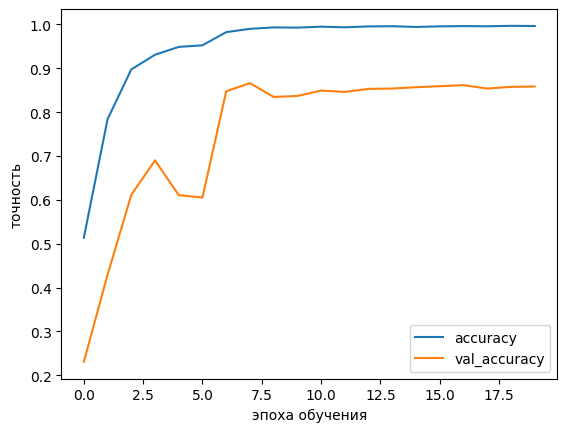

In [ ]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('эпоха обучения')
plt.ylabel('точность')
plt.legend()
plt.show()

###Тестирование обученной модели

In [ ]:
model.load_weights('/content/model.h5')

In [ ]:
overall_result = list()
for i in val_index:
  result = list()
  correct = raw_data[i]['class']
  predicted = list(le.inverse_transform(np.argmax(model([raw_data[i]['data'][0], raw_data[i]['data'][1], raw_data[i]['data'][2], raw_data[i]['data'][3]]), axis=1)))
  for j in predicted:
    if j == correct:
      result.append('True')
    else:
      result.append('False')
  overall_result.extend(result)
  print('index:'+str(i)+' ''class:'+str(raw_data[i]['class'])+' '+'True:'+str(result.count('True'))+' '+'False:'+str(result.count('False')))
print('accuracy = '+str(overall_result.count('True')/len(overall_result)))

index:17 class:c True:100 False:0
index:42 class:r True:100 False:0
index:51 class:y True:95 False:5
index:64 class:c True:63 False:37
index:72 class:r True:46 False:54
index:76 class:b True:96 False:4
index:78 class:y True:96 False:4
index:80 class:b True:90 False:10
index:82 class:c True:98 False:2
index:84 class:y True:100 False:0
index:88 class:c True:100 False:0
index:92 class:g True:100 False:0
index:96 class:m True:42 False:58
accuracy = 0.8661538461538462


In [ ]:
overall_result = list()
for i in test_index:
  result = list()
  correct = raw_data[i]['class']
  predicted = list(le.inverse_transform(np.argmax(model([raw_data[i]['data'][0], raw_data[i]['data'][1], raw_data[i]['data'][2], raw_data[i]['data'][3]]), axis=1)))
  for j in predicted:
    if j == correct:
      result.append('True')
    else:
      result.append('False')
  overall_result.extend(result)
  print('index:'+str(i)+' ''class:'+str(raw_data[i]['class'])+' '+'True:'+str(result.count('True'))+' '+'False:'+str(result.count('False')))
print('accuracy = '+str(overall_result.count('True')/len(overall_result)))

index:33 class:y True:100 False:0
index:52 class:r True:34 False:66
index:54 class:b True:100 False:0
index:57 class:c True:85 False:15
index:58 class:y True:100 False:0
index:68 class:g True:100 False:0
index:71 class:c True:49 False:51
index:75 class:m True:100 False:0
index:77 class:r True:76 False:24
index:81 class:y True:44 False:56
index:85 class:y True:100 False:0
index:86 class:c True:100 False:0
accuracy = 0.8233333333333334


In [ ]:
y_test = list(le.inverse_transform(np.argmax(test_output, axis=1)))

In [ ]:
y_pred = list(le.inverse_transform(np.argmax(model.predict([test_data[0], test_data[1], test_data[2], test_data[3]]), axis=1)))

38/38 [==============================] - 0s 3ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[100   0   0   0   0   0]
 [  0 260  37   3   0   0]
 [  0   0 100   0   0   0]
 [  0   0   0 100   0   0]
 [ 91   0   0  18  91   0]
 [  0  89   0   0   0 311]]


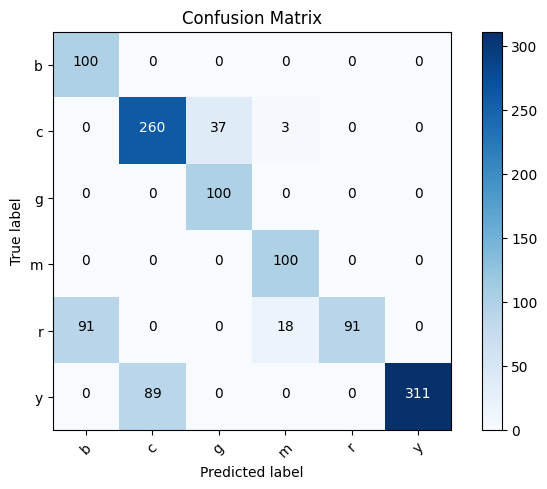

In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_true=y_test, y_pred=y_pred), classes=list(le.classes_), title='Confusion Matrix')

In [ ]:
Y_test = val_output
y_pred = model.predict([val_data[0],val_data[1], val_data[2], val_data[3]])
print(classification_report(list(le.inverse_transform(np.argmax(Y_test, axis=1))), list(le.inverse_transform(np.argmax(y_pred, axis=1)))))

13/13 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           b       0.00      0.00      0.00         0
           c       0.98      0.50      0.66       200
           g       0.00      0.00      0.00         0
           m       0.00      0.00      0.00         0
           r       0.00      0.00      0.00         0
           y       0.99      0.95      0.97       200

    accuracy                           0.73       400
   macro avg       0.33      0.24      0.27       400
weighted avg       0.99      0.73      0.82       400



In [ ]:
Y_test = test_output
y_pred = model.predict([test_data[0],test_data[1], test_data[2], test_data[3]])
print(classification_report(list(le.inverse_transform(np.argmax(Y_test, axis=1))), list(le.inverse_transform(np.argmax(y_pred, axis=1)))))

19/19 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           b       0.00      0.00      0.00       100
           c       0.00      0.00      0.00       100
           g       0.00      0.00      0.00       100
           m       0.39      0.62      0.48       100
           r       0.71      0.58      0.64       100
           y       0.00      0.00      0.00       100

    accuracy                           0.20       600
   macro avg       0.18      0.20      0.19       600
weighted avg       0.18      0.20      0.19       600



In [ ]:
model.save('model_6classes_final.h5')

#Предсказания

##Прогнозирование ориентации кристалла

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import os
import numpy as np
import tensorflow as tf
import math

###Загрузка изображений

In [ ]:
uploaded = list(files.upload().keys())
uploaded.sort()
img_list = list()
for file in uploaded:
  img_list.append(image.load_img(file, target_size = (10, 10)))
  os.remove(file)

Saving 1 79 синий 146,7_ 53,2_ 45,1.png to 1 79 синий 146,7_ 53,2_ 45,1.png
Saving 2 79 синий 146,7_ 53,2_ 45,1.png to 2 79 синий 146,7_ 53,2_ 45,1.png
Saving 3 79 синий 146,7_ 53,2_ 45,1.png to 3 79 синий 146,7_ 53,2_ 45,1.png
Saving 4 79 синий 146,7_ 53,2_ 45,1.png to 4 79 синий 146,7_ 53,2_ 45,1.png


###Визуализация загруженных изображений

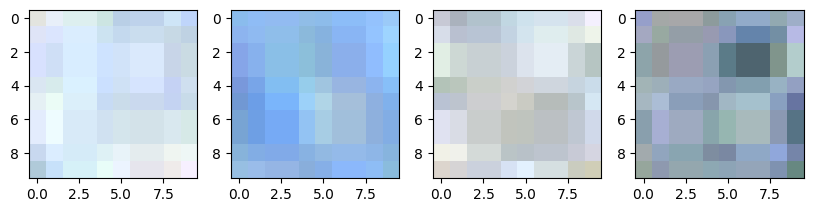

In [ ]:
if len(img_list) == 4:
  plt.figure(figsize=(10, 10))

for i in range(len(img_list)):
  plt.subplot(1, len(img_list), i+1)
  plt.imshow(img_list[i])

###Предобработка данных

In [ ]:
x = list()
for img in img_list:
  x.append(image.img_to_array(img).reshape(1, 10, 10, 3) / 255)

###Загрузка модели и ее использование

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Предсказание

In [ ]:
model = load_model('/content/drive/MyDrive/model_6classes.h5')

In [ ]:
prediction = model.predict([result_arr[0], result_arr[1], result_arr[2], result_arr[3]])

105/105 [==============================] - 9s 4ms/step


In [ ]:
result = np.argmax(prediction, axis=1)

#Построение IPF-Z карты

In [ ]:
import math
import numba
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageDraw, ImageFilter
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, BatchNormalization, Input, concatenate, Add
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.utils import img_to_array
from PIL import Image
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn import preprocessing
import matplotlib.colors as mcolors
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array

In [ ]:
colors = mcolors.BASE_COLORS
colors.pop('k')
colors.pop('w')
colors['g'] = (0, 1, 0)
colors['c'] = (0, 1, 1)
colors['m'] = (1, 0, 1)
colors['y'] = (1, 1, 0)

In [ ]:
model = load_model('/content/drive/MyDrive/model_6classes_final.h5')
le = preprocessing.LabelEncoder()
le.classes_ = np.load('/content/drive/MyDrive/classes.npy')

In [ ]:
input = list()
img1 = Image.open('/content/drive/MyDrive/1.png').convert("RGB")
img2 = Image.open('/content/drive/MyDrive/2.png').convert("RGB")
img3 = Image.open('/content/drive/MyDrive/3.png').convert("RGB")
img4 = Image.open('/content/drive/MyDrive/4.png').convert("RGB")
max_x, max_y = img1.size
draw = ImageDraw.Draw(img1)
img1.show()
for i in range(0,max_x, 10):
    for j in range(0,max_y, 10):
        x1 = i
        x2 = i+10
        y1 = j
        y2 = j+10
        x = list()
        x.append(image.img_to_array(img1.crop((x1, y1, x2, y2))).reshape(10, 10, 3) / 255)
        x.append(image.img_to_array(img2.crop((x1, y1, x2, y2))).reshape(10, 10, 3) / 255)
        x.append(image.img_to_array(img3.crop((x1, y1, x2, y2))).reshape(10, 10, 3) / 255)
        x.append(image.img_to_array(img4.crop((x1, y1, x2, y2))).reshape(10, 10, 3) / 255)
        input.append(np.array(x))
input = np.array(input)
input = input.reshape(input.shape[1], input.shape[0], input.shape[2], input.shape[3], input.shape[4])
input = input.reshape(input.shape[1], input.shape[0], input.shape[2], input.shape[3], input.shape[4])
prediction = model.predict([input[:,0], input[:,1], input[:,2], input[:,3]])
color_list = list(le.inverse_transform(np.argmax(prediction, axis=1)))
k=0
for i in range(0,max_x, 10):
    for j in range(0,max_y, 10):
      color_value = colors[color_list[k]]
      new_color = (color_value[0]*255,color_value[1]*255,color_value[2]*255)
      draw.rectangle((i, j, i+10, j+10), width=1, fill=new_color)
      k = k + 1

img1.save('created_mask.png')
img1.show()

In [ ]:
model = load_model('/content/drive/MyDrive/model_7х7.h5')

In [ ]:
plastin = list()
plastin.append(Image.open('/content/drive/MyDrive/1.png').convert("RGB").resize((1000, 1000)))
plastin.append(Image.open('/content/drive/MyDrive/2.png').convert("RGB").resize((1000, 1000)))
plastin_ds = list()
for x in range(plastin[0].size[0]):
    for y in range(plastin[0].size[1]):
        inp = np.zeros(294)
        index = 0
        for i in range(-3, 4):
            for j in range(-3, 4):
              for k in range(3):
                if not(0 <= (x + i) < plastin[0].size[0]) or not(0 <= (y + j) < plastin[0].size[1]):
                    inp[index] = 0
                    inp[147 + index] = 0
                else:
                    inp[index] = plastin[0].getpixel((x+i, y+j))[k] / 255
                    inp[147 + index] = plastin[1].getpixel((x+i, y+j))[k] / 255
                index += 1
        plastin_ds.append(inp)

plastin_ds = np.array(plastin_ds)
out = (model.predict(plastin_ds)* 255).astype(np.uint8)
Image.fromarray(out.reshape(plastin[0].size[0], plastin[0].size[1], 3)).save('77 top prod.png')
files.download('77 top prod.png')

31250/31250 [==============================] - 55s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>